# UES Workload Evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

## Data loading

Nested Loop Join enabled:

In [2]:
df_imp_nlj = pd.read_csv("workloads/job-implicit-cout.csv")

In [3]:
df_exp_nlj = pd.read_csv("workloads/job-explicit-cout.csv")

Nested Loop Join disabled:

In [4]:
df_imp = pd.read_csv("workloads/job-implicit-nonestloop-cout.csv")

In [5]:
df_exp = pd.read_csv("workloads/job-explicit-nonestloop-cout.csv")

## Calculating $C_{out}$ differences between NLJ/non-NLJ setups

For each workload (implicit queries and explicit queries), calculate the $C_{out}$ value when NLJ is enabled or not.

In [6]:
proj = ["label", "cout"]
df_imp_comb = pd.merge(df_imp[proj], df_imp_nlj[proj], on="label", suffixes=("", "_nlj"))

**Explanation:**

Implicit/explicit workload results will be summarized using two figures, each.
In order to do so, the $C_{out}$ values of the plans with or without NLJ are aggregated into a single indicator:

- if the value is negative, having NLJ disabled leads to better plans
- if the value is positive, having NLJ enabled leads to better plans

The following figure depicts the absolute difference, i.e. how often the enabling/disabling NLJ leads to a better plan, and how much better the plan is.

The y-axis shows the number of queries whose $C_{out}$ value fall into the corresponding bin on the x-axis. Each bin denotes a specific range of $C_{out}$ differences ($cout_{non-NLJ} - cout_{NLJ}$).

<AxesSubplot:title={'center':'implicit queries, absolute cout differences'}, ylabel='Frequency'>

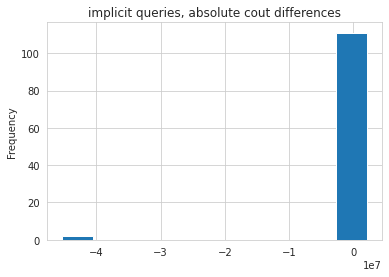

In [7]:
df_imp_comb["cout_diff"] = df_imp_comb.cout - df_imp_comb.cout_nlj
df_imp_comb.cout_diff.plot(kind="hist", title="implicit queries, absolute cout differences")

The second figure summarizes how many queries receive either better (-1), equivalent (0), or worse (+1) plans when enabling NLJs.

<AxesSubplot:title={'center':'implicit queries, cout difference categories'}, ylabel='Frequency'>

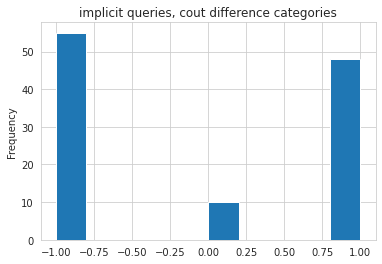

In [9]:
np.sign(df_imp_comb.cout_diff).plot(kind="hist", title="implicit queries, cout difference categories")

The same visualization, but for the explicit workload:

In [10]:
df_exp_comb = pd.merge(df_exp[proj], df_exp_nlj[proj], on="label", suffixes=("", "_nlj"))

<AxesSubplot:title={'center':'explicit queries, absolute cout differences'}, ylabel='Frequency'>

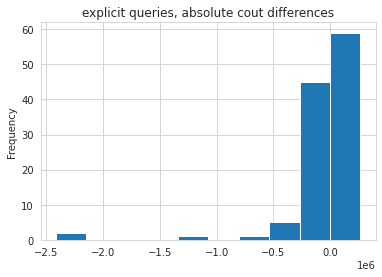

In [11]:
df_exp_comb["cout_diff"] = df_exp_comb.cout - df_exp_comb.cout_nlj
df_exp_comb.cout_diff.plot(kind="hist", title="explicit queries, absolute cout differences")

<AxesSubplot:title={'center':'explicit queries, cout difference categories'}, ylabel='Frequency'>

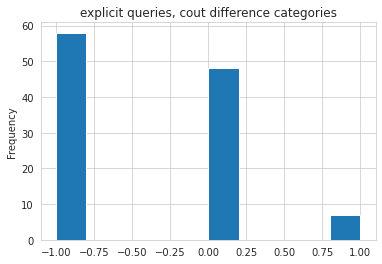

In [12]:
np.sign(df_exp_comb.cout_diff).plot(kind="hist", title="explicit queries, cout difference categories")

## Calculating $C_{out}$ differences between implicit/explicit queries

In [13]:
def qerror1(first, second):
    data = np.asarray([first, second])
    return (np.max(data, axis=0)+1) / (np.min(data, axis=0)+1)

In [14]:
df_impexp_nlj = pd.merge(df_imp_nlj[proj], df_exp_nlj[proj], on="label", suffixes=("_imp", "_exp"))
df_impexp_nlj.set_index("label", inplace=True)

In [15]:
df_impexp_nlj["qerror1"] = qerror1(df_impexp_nlj.cout_imp, df_impexp_nlj.cout_exp)

In [16]:
df_impexp_nlj["exp_improvement"] = df_impexp_nlj.cout_imp.replace(0, np.nan) / df_impexp_nlj.cout_exp.replace(0, np.nan)
df_impexp_nlj

,cout_imp,cout_exp,qerror1,exp_improvement
label,,,,
3c,15579,285667,18.335558,0.054536
1d,34,29,1.166667,1.172414
15d,497354,534476,1.074639,0.930545
28c,1855014,598609,3.098871,3.098874
33a,3402,266214,78.229503,0.012779
...,...,...,...,...
33b,3403,2793,1.218325,1.218403
18b,74312,68354,1.087163,1.087164
3a,8715,58222,6.680014,0.149686


In [17]:
df_impexp = pd.merge(df_imp[proj], df_exp[proj], on="label", suffixes=("_imp", "_exp"))
df_impexp.set_index("label", inplace=True)

In [18]:
df_impexp["qerror1"] = qerror1(df_impexp.cout_imp, df_impexp.cout_exp)

In [19]:
df_impexp["exp_improvement"] = df_impexp.cout_imp.replace(0, np.nan) / df_impexp.cout_exp.replace(np.nan)
df_impexp

,cout_imp,cout_exp,qerror1,exp_improvement
label,,,,
10a,24672,48314,1.958213,0.510659
10b,6995,43,159.000000,162.674419
10c,1675125,1683250,1.004850,0.995173
11a,4666,6157,1.319477,0.757837
11b,1158,868411,749.276963,0.001333
...,...,...,...,...
8d,1665117,1595836,1.043414,1.043414
9a,179639,1809,99.248619,99.302930
9b,143771,1164,123.409442,123.514605


In [20]:
df_impexp["nlj"] = "deactivated"
df_impexp_nlj["nlj"] = "activated"

In [21]:
df_impexp_comb = pd.concat([df_impexp.reset_index(), df_impexp_nlj.reset_index()])
df_impexp_comb

,label,cout_imp,cout_exp,qerror1,exp_improvement,nlj
0,10a,24672,48314,1.958213,0.510659,deactivated
1,10b,6995,43,159.000000,162.674419,deactivated
2,10c,1675125,1683250,1.004850,0.995173,deactivated
3,11a,4666,6157,1.319477,0.757837,deactivated
4,11b,1158,868411,749.276963,0.001333,deactivated
...,...,...,...,...,...,...
108,33b,3403,2793,1.218325,1.218403,activated
109,18b,74312,68354,1.087163,1.087164,activated
110,3a,8715,58222,6.680014,0.149686,activated
111,14b,13541,317058,23.413011,0.042708,activated


The following figure contrast how much the $C_{out}$ value improves (i.e. gets smaller) when using the explicit representation of the JOB queries instead of the implicit one. In order to do so, an improvement factor is calculated (as the ratio $\frac{cout_{impl}}{cout_{expl}}$).

A value $\geq 1$ indicates improvement, whereas a value $\leq 1$ indicates decline. This calculation is repeated for workloads using NLJs and for those with just Hash Joins.

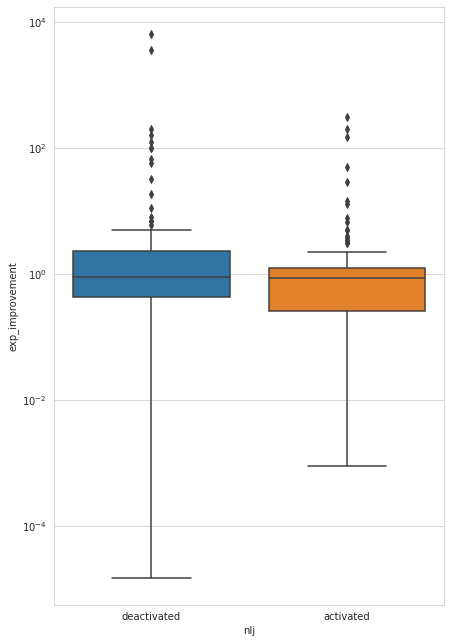

In [22]:
fig, ax = plt.subplots(figsize=(7,11))
g = sns.boxplot(data=df_impexp_comb, y="exp_improvement", x="nlj", ax=ax)
g.set_yscale("log")